In [1]:
import os

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [2]:
train = pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/test.csv")

# 1. date 변수 변환


In [3]:
#date 컬럼을 판다스의 datetime 변수형으로 변환한다.
train['date2'] = pd.to_datetime(train['date'])

In [4]:
#date 컬럼으로부터 요일을 뽑아낸다.
train['weekday'] = train['date2'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])

In [5]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [6]:
del train['date2']
del test['date2']

# 2. in_out 변수 변환


In [7]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [8]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

# 3. 승차, 하차 시간대 통합 작업


In [9]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [10]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

In [11]:
cor=train22.corr()

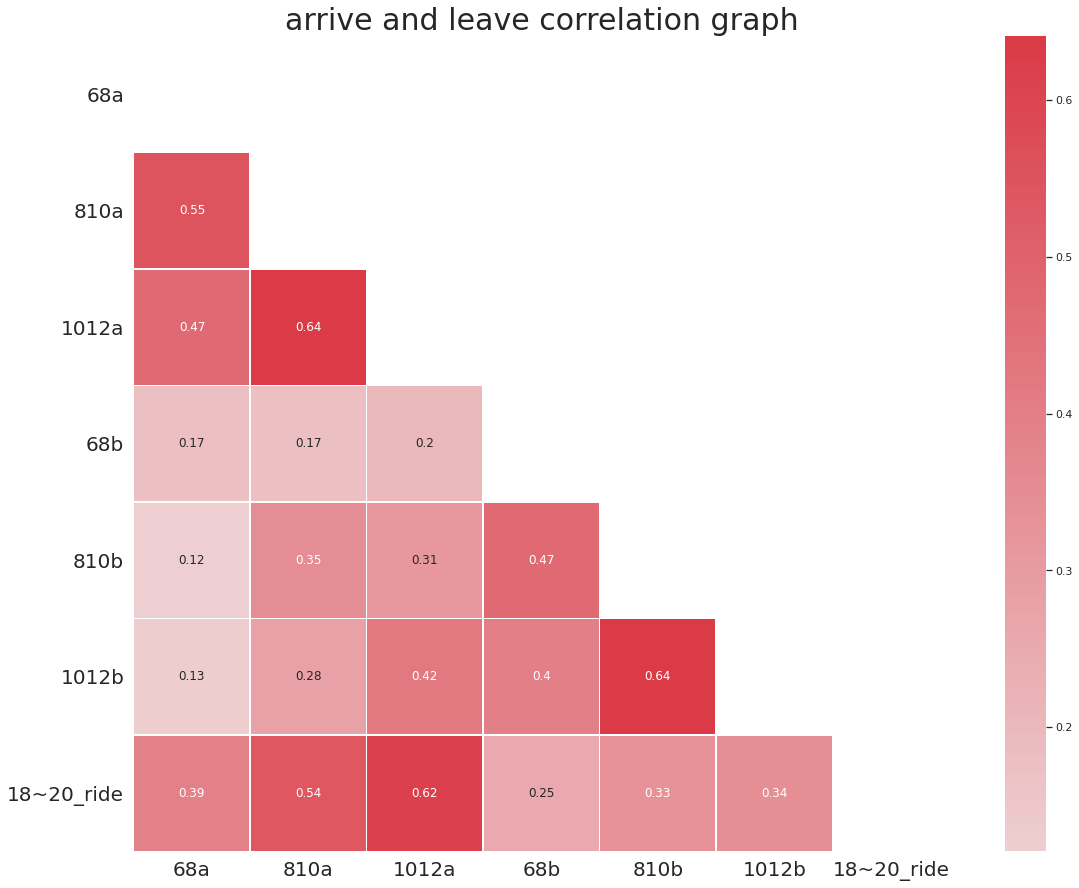

In [12]:
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [13]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

# 4. 좌표 데이터를 이용한 Feature Engineering
## 4-1. 측정소 위치 및 정류장 위치 확인

In [14]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

In [15]:
#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [16]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

In [17]:
#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

Output hidden; open in https://colab.research.google.com to view.

## 4-2. 측정소와 정류장 사이 거리 계산 적용


In [18]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

In [19]:
train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [20]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )

In [21]:
total.head()

,jeju,gosan,seongsan,po
0,4.286659,37.692766,37.713630,27.841879
1,4.966848,37.008492,38.465822,27.996179
2,6.330746,35.642126,39.259820,27.496551
3,3.575272,38.643401,38.386802,29.579404
4,30.652098,23.648361,45.899140,14.269792


In [23]:
train['dist_name'] = total.apply(lambda x: x.argmin(),axis=1)

In [24]:
data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

In [25]:
Counter(data22['dist_name'])

Counter({0: 1479, 1: 659, 2: 597, 3: 828})

In [26]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [27]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3


# 5. 외부 실제 측정 데이터 활용


In [28]:
# https://data.kma.go.kr/cmmn/main.do
#데이터 불러오기
raining=pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/OBS_ASOS_TIM_20210114113345.csv",engine='python',encoding="cp949")

In [29]:
#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

In [30]:
raining.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,jeju,제주,2019-09-01 01:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
1,jeju,제주,2019-09-01 02:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
2,jeju,제주,2019-09-01 03:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
3,jeju,제주,2019-09-01 04:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN
4,jeju,제주,2019-09-01 05:00,23.3,NaN,1.2,180.0,71,1013.6,1016.0,NaN,NaN


In [31]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 
raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 


In [32]:
# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

In [33]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

In [34]:
# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

In [35]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3


In [36]:
rain3.head()

,dist_name,date,기온(°C),강수량(mm)
0,gosan,2019-09-01,22.018182,0.800000
1,gosan,2019-09-02,26.145455,0.700000
2,gosan,2019-09-03,25.254545,3.866667
3,gosan,2019-09-04,24.463636,0.266667
4,gosan,2019-09-05,27.136364,0.000000


In [37]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3


In [39]:
train["dist_name"] = train["dist_name"].apply(lambda x: str(x))
test["dist_name"] = test["dist_name"].apply(lambda x: str(x))

In [40]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [41]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

In [42]:
train2.shape, test2.shape, train.shape, test.shape
((415423, 44), (228170, 43), (415423, 39), (228170, 38))

((415423, 44), (228170, 43), (415423, 39), (228170, 38))

In [43]:
train2.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_0,dist_name_1,dist_name_2,dist_name_3
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,NaN,NaN,1,0,0,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,NaN,NaN,1,0,0,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,NaN,NaN,1,0,0,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,NaN,NaN,1,0,0,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,NaN,NaN,0,0,0,1


# 6. randomforest을 활용한 모델링
## 6-1. 변수 선택 및 train data sampling


In [44]:
train2.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_0,dist_name_1,dist_name_2,dist_name_3
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,NaN,NaN,1,0,0,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,NaN,NaN,1,0,0,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,NaN,NaN,1,0,0,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,NaN,NaN,1,0,0,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,NaN,NaN,0,0,0,1


In [51]:
train2 = train2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})
test2 = test2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})

In [52]:
train2

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_jeju,dist_name_gosan,dist_name_seongsan,dist_name_po
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,NaN,NaN,1,0,0,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,NaN,NaN,1,0,0,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,NaN,NaN,1,0,0,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,NaN,NaN,1,0,0,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,4.0,0.0,0.0,0.0,0.0,0.0,27.117280,16.319339,57.465292,33.738981,NaN,NaN,0,1,0,0
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,4.0,0.0,0.0,0.0,0.0,0.0,2.134693,39.904297,36.202951,28.484278,NaN,NaN,1,0,0,0
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,40.039090,11.626985,60.041783,28.249863,NaN,NaN,0,1,0,0
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,20.355649,23.876917,52.933244,33.392008,NaN,NaN,1,0,0,0


In [53]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

In [54]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

In [55]:
X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

In [56]:
X_train.shape, y_train.shape

((4154, 26), (4154, 1))

## 6-2. GridSearCV and RandomForestRegressor

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

In [57]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

In [58]:
X_test=test2[input_var]

In [59]:
X_train.shape, y_train.shape, X_test.shape

((415423, 26), (415423, 1), (228170, 26))

In [ ]:
# best_params_를 통해서 나온 값을 투입
rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=500,random_state=1217)

rf.fit(X_train,y_train) #학습 

In [ ]:
test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("dacon_base_middle2.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

#해당 코드 소요 시간 5분